In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense 
import tensorflow_probability as tfp

In [2]:
class PolicyGradientNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(PolicyGradientNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        pi = self.pi(value)

        return pi

In [3]:
class Agent:
    def __init__(self, alpha=0.003, gamma=0.99, n_actions=4,
                 layer1_size=256, layer2_size=256):

        self.gamma = gamma
        self.lr = alpha
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.policy = PolicyGradientNetwork(n_actions=n_actions)
        self.policy.compile(optimizer=Adam(learning_rate=self.lr))

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        probs = self.policy(state)
        action_probs = tfp.distributions.Categorical(probs=probs)
        action = action_probs.sample()

        return action.numpy()[0]

    def store_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)

    def learn(self):
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = np.array(self.reward_memory)

        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum
        
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.policy(state)
                action_probs = tfp.distributions.Categorical(probs=probs)
                log_prob = action_probs.log_prob(actions[idx])
                loss += -g * tf.squeeze(log_prob)

        gradient = tape.gradient(loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

In [4]:
def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

episode:  0 score: -204.7 average score -204.7
episode:  1000 score: -20.1 average score 2.9
episode:  2000 score: 278.7 average score 153.0
episode:  3000 score: -9.7 average score 166.8
episode:  4000 score: 304.8 average score 213.3
episode:  5000 score: 225.4 average score 121.7
episode:  6000 score: 33.6 average score 258.0
episode:  7000 score: -4.7 average score 187.0
episode:  8000 score: 34.4 average score 201.3
episode:  9000 score: 210.2 average score 198.7


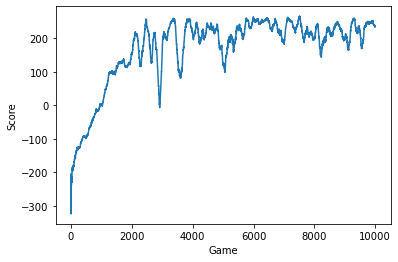

In [6]:
agent = Agent(alpha=0.0005,  gamma=0.99,n_actions=4)

env = gym.make('LunarLander-v2')
score_history = []

num_episodes = 10000

for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward)
        observation = observation_
        score += reward
    score_history.append(score)

    agent.learn()
    avg_score = np.mean(score_history[-100:])
    if i %1000 == 0: 
        print('episode: ', i,'score: %.1f' % score,
        'average score %.1f' % avg_score)

filename = 'lunar-lander.png'
plotLearning(score_history, filename=filename, window=100)